### Build 4th CSV for Blind Experiment to Asses Masking Results

- 08-25-22
- Joel Stremmel

##### About

This notebook reads the output from the masking experiments and creates new `all_info` and single `exp_data` CSVs.

##### Imports

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower

##### Set Run Parameters

In [2]:
BASE_PATH = "../results/masking/exp4_msp_rand_soc_outputs/"
GLOBAL_ALL_INFO_OUTPATH = "../results/masking/exp4_global_dfs/global_all_info.csv"
GLOBAL_EXP_DATA_OUTPATH = "../results/masking/exp4_global_dfs/global_exp_data.csv"
SEED = 42
SAMPLE_SIZE = 80  # distinct label, doc, algo combinations

##### Set Seed

In [3]:
np.random.seed(SEED)

##### Load Data and Add Index to Indicate Origin
Only grab new results for this 2nd iteration

In [4]:
all_info_dfs = []
exp_data_dfs = []
for i, file in enumerate(glob.glob(f"{BASE_PATH}*all_info*")):
    if "all_info" in file:

        # Read all info file
        print(f"Processing file: {file}...")
        d_all_info_df = pd.read_csv(file)
        d_all_info_df["row_id"] = d_all_info_df["row_id"].apply(
            lambda x: f"{i}_" + str(x)
        )
        all_info_dfs.append(d_all_info_df)

        # Read exp data file
        companion_file = file.replace("all_info", "exp_data")
        print(f"Processing companion file: {companion_file}...")
        d_exp_data_df = pd.read_csv(companion_file)
        d_exp_data_df["row_id"] = d_exp_data_df["row_id"].apply(
            lambda x: f"{i}_" + str(x)
        )
        exp_data_dfs.append(d_exp_data_df)

    else:
        print(f"Skipped reading unexpected file: {file}.")

Processing file: ../results/masking/exp4_msp_rand_soc_outputs/sample_1228_all_info_20.42_hours.csv...
Processing companion file: ../results/masking/exp4_msp_rand_soc_outputs/sample_1228_exp_data_20.42_hours.csv...
Processing file: ../results/masking/exp4_msp_rand_soc_outputs/sample_1298_all_info_0.97_hours.csv...
Processing companion file: ../results/masking/exp4_msp_rand_soc_outputs/sample_1298_exp_data_0.97_hours.csv...
Processing file: ../results/masking/exp4_msp_rand_soc_outputs/sample_491_all_info_12.34_hours.csv...
Processing companion file: ../results/masking/exp4_msp_rand_soc_outputs/sample_491_exp_data_12.34_hours.csv...
Processing file: ../results/masking/exp4_msp_rand_soc_outputs/sample_1306_all_info_0.88_hours.csv...
Processing companion file: ../results/masking/exp4_msp_rand_soc_outputs/sample_1306_exp_data_0.88_hours.csv...
Processing file: ../results/masking/exp4_msp_rand_soc_outputs/sample_524_all_info_0.84_hours.csv...
Processing companion file: ../results/masking/exp4

##### Combine Dataframes

In [5]:
all_info_df = pd.concat(all_info_dfs)
exp_data_df = pd.concat(exp_data_dfs)
combined_df = pd.merge(
    all_info_df,
    exp_data_df.drop(["icd_code", "icd_description", "text_block"], axis=1),
    on="row_id",
    how="inner",
)
print(all_info_df.shape)
print(exp_data_df.shape)
print(combined_df.shape)

(1850, 12)
(1850, 5)
(1850, 13)


##### Create Dataframe of All Label, Document, Algorithm Combinations

In [6]:
label_doc_algo_df = combined_df[["icd_code", "sample", "P"]].drop_duplicates()
print(label_doc_algo_df.shape)

(370, 3)


##### Identify Number of Samples to Take such that Each Algorithm is Represented the Same Number of Times

In [7]:
counts = label_doc_algo_df.groupby("P").size().to_frame("size").reset_index()
counts_dict = dict(list(zip(counts["P"].tolist(), counts["size"].tolist())))
num_samples = min([min(counts_dict.values()), SAMPLE_SIZE])
print(counts_dict)
print(
    f"Will sample text blocks from {num_samples} of each label, doc, algo combination..."
)

{'0.1': 139, 'RANDOM': 139, 'SOC': 92}
Will sample text blocks from 80 of each label, doc, algo combination...


##### Sample such that Each Algorithm is Represented the Same Number of Times

In [8]:
label_doc_algo_sample_dfs = []
for p in counts_dict.keys():
    sample_df = label_doc_algo_df[label_doc_algo_df["P"] == p].sample(
        num_samples, replace=False, random_state=SEED
    )
    label_doc_algo_sample_dfs.append(sample_df)
label_doc_algo_sample_df = pd.concat(label_doc_algo_sample_dfs)
print(label_doc_algo_sample_df.shape)

(240, 3)


##### Join for Text Blocks Associated with Sampled Label, Document, Algorithm Combinations

In [9]:
reduced_df = pd.merge(
    combined_df, label_doc_algo_sample_df, on=["icd_code", "sample", "P"], how="inner"
)

##### Assign Global Random ID

In [10]:
global_row_ids = np.arange(len(reduced_df))
np.random.shuffle(global_row_ids)
reduced_df["global_row_id"] = global_row_ids

##### Check Power for Two Sample T-Test

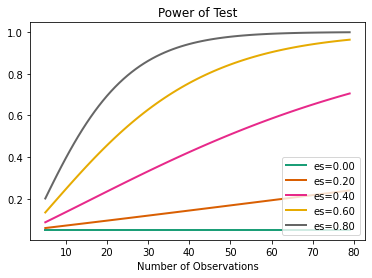

In [11]:
effect_sizes = np.arange(0, 1, 0.2, dtype=float)
sample_sizes = np.array(range(5, num_samples))
analysis = TTestIndPower()
analysis.plot_power(
    dep_var="nobs", nobs=sample_sizes, effect_size=effect_sizes, alpha=0.05
)
plt.show()

##### Inspect Sample Dataframe

In [12]:
print(reduced_df.shape)
print(reduced_df.head())

(1200, 14)
   avg_score_diff                                         text_block icd_code  \
0        0.034548  admission date discharge date date of birth se...    287.5   
1        0.026743  medicine allergies ketamine morphine zosyn un ...    287.5   
2        0.015898    o n arrival to mic u and remained intubated for    287.5   
3        0.013291  shock multifocal pneumonia with pleural effusi...    287.5   
4        0.011124            pathology s p multiple ex lap s and r e    287.5   

                 icd_description  sample  draws   K    P  runtime_hours  \
0  Thrombocytopenia, unspecified    1228    100  10  SOC          20.42   
1  Thrombocytopenia, unspecified    1228    100  10  SOC          20.42   
2  Thrombocytopenia, unspecified    1228    100  10  SOC          20.42   
3  Thrombocytopenia, unspecified    1228    100  10  SOC          20.42   
4  Thrombocytopenia, unspecified    1228    100  10  SOC          20.42   

  row_id  p_val   N informative_0_or_1  global_row_

##### Hide Information from Sample Dataframe to Create Experiment Dataframe

In [13]:
global_exp_data_df = reduced_df[["global_row_id"] + exp_data_df.columns.tolist()].drop(
    "row_id", 1
)

<ipython-input-13-77e22cc5e760>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  global_exp_data_df = reduced_df[['global_row_id'] + exp_data_df.columns.tolist()].drop('row_id', 1)


##### Inspect Global Dataframes

In [14]:
print(global_exp_data_df.shape)
print(global_exp_data_df.head())

(1200, 5)
   global_row_id icd_code                icd_description  \
0           1178    287.5  Thrombocytopenia, unspecified   
1            865    287.5  Thrombocytopenia, unspecified   
2            101    287.5  Thrombocytopenia, unspecified   
3            439    287.5  Thrombocytopenia, unspecified   
4             58    287.5  Thrombocytopenia, unspecified   

                                          text_block informative_0_or_1  
0  admission date discharge date date of birth se...                  -  
1  medicine allergies ketamine morphine zosyn un ...                  -  
2    o n arrival to mic u and remained intubated for                  -  
3  shock multifocal pneumonia with pleural effusi...                  -  
4            pathology s p multiple ex lap s and r e                  -  


##### Shuffle Rows in Experiment Dataframe

In [15]:
global_exp_data_df = global_exp_data_df.sample(frac=1)
print(global_exp_data_df.shape)
print(global_exp_data_df.head())

(1200, 5)
      global_row_id icd_code  \
410             593   518.81   
199             275    272.0   
82              844    403.9   
1124            763   414.01   
1038            400    287.5   

                                        icd_description  \
410                           Acute respiratory failure   
199                           Pure hypercholesterolemia   
82    Hypertensive chronic kidney disease, unspecifi...   
1124  Coronary atherosclerosis of native coronary ar...   
1038                      Thrombocytopenia, unspecified   

                                             text_block informative_0_or_1  
410   w persistent hyper bilirub inemia the most lik...                  -  
199   of dementia htn and stroke unclear residual de...                  -  
82    admission date discharge date date of birth se...                  -  
1124  normal size with normal cardiac doctor last na...                  -  
1038  admission date discharge date date of birth se...  

##### Create Global All Info Dataframe

In [16]:
global_all_info_df = reduced_df.drop("informative_0_or_1", 1)

<ipython-input-16-df437d3f0e99>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  global_all_info_df = reduced_df.drop('informative_0_or_1', 1)


##### Inspect All Info Dataframe

In [17]:
print(global_all_info_df.shape)
print(global_all_info_df.head())

(1200, 13)
   avg_score_diff                                         text_block icd_code  \
0        0.034548  admission date discharge date date of birth se...    287.5   
1        0.026743  medicine allergies ketamine morphine zosyn un ...    287.5   
2        0.015898    o n arrival to mic u and remained intubated for    287.5   
3        0.013291  shock multifocal pneumonia with pleural effusi...    287.5   
4        0.011124            pathology s p multiple ex lap s and r e    287.5   

                 icd_description  sample  draws   K    P  runtime_hours  \
0  Thrombocytopenia, unspecified    1228    100  10  SOC          20.42   
1  Thrombocytopenia, unspecified    1228    100  10  SOC          20.42   
2  Thrombocytopenia, unspecified    1228    100  10  SOC          20.42   
3  Thrombocytopenia, unspecified    1228    100  10  SOC          20.42   
4  Thrombocytopenia, unspecified    1228    100  10  SOC          20.42   

  row_id  p_val   N  global_row_id  
0    0_6    Na

##### Save Global Dataframes

In [18]:
global_all_info_df.to_csv(GLOBAL_ALL_INFO_OUTPATH, index=False)
global_exp_data_df.to_csv(GLOBAL_EXP_DATA_OUTPATH, index=False)